## Operating Instructions

1. **Install Required Packages**  
   If any packages are not already installed on your local machine, use the following command to install them:
   
   ```bash
   pip install [packagename]

2. **Update File Paths**  
   Update the file paths in the code as needed to point to the correct locations on your system. Ensure that the paths to your data files, input files, and output directories are correct.

3. **Execution**  
   Most cells should be able to be run independently if a file path is provided at the beginning of the cell content



### Data Cleaning For Coordinates ###


In [ ]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
from shapely.geometry import Point


# Load the CSV file
df = pd.read_csv(r"C:\Users\jonch\COMP3522\submission\EDA_Dependencies\STOP.csv")
print(df.head())  


# convert coordinates to lat/long
transformer = Transformer.from_crs("EPSG:2326", "EPSG:4326", always_xy=True)
df["longitude"], df["latitude"] = transformer.transform(df["X"], df["Y"])

districts = gpd.read_file("C:\Users\jonch\COMP3522\submission\EDA_Dependencies\hksar_18_district_boundary.json")

print(districts.columns)  
print(districts.head())  

geometry = [Point(lon, lat) for lon, lat in zip(df["longitude"], df["latitude"])]
bus_stops = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

#spatial join
result = gpd.sjoin(bus_stops, districts, how="left", predicate="within")


df["district"] = result["District"]

df.to_csv("STOP_with_districts.csv", index=False)

### Cleaning Data for Bus Stops ###

In [ ]:
import pandas as pd

rstop_df = pd.read_csv(r"C:\Users\jonch\COMP3522\submission\EDA_Dependencies\RSTOP.csv", usecols=['ROUTE_ID', 'ROUTE_SEQ', 'STOP_SEQ', 'STOP_ID', 'STOP_NAMEE'])
route_df = pd.read_csv(r"C:\Users\jonch\COMP3522\submission\EDA_Dependencies\ROUTE.csv", usecols=['ROUTE_ID', 'COMPANY_CODE', 'ROUTE_NAMEE'])
fare_df = pd.read_csv(r"C:\Users\jonch\COMP3522\submission\EDA_Dependencies\FARE.csv", usecols=['ROUTE_ID', 'ROUTE_SEQ', 'ON_SEQ', 'OFF_SEQ', 'PRICE'])
stop_df = pd.read_csv(r"C:\Users\jonch\COMP3522\submission\EDA_Dependencies\STOP_with_districts.csv", usecols=['STOP_ID','STOP_TYPE','X','Y', 'Long', 'Lat', 'District'])

# Merge to get ON stop names
on_stop = rstop_df[['ROUTE_ID', 'ROUTE_SEQ', 'STOP_SEQ', 'STOP_NAMEE', 'STOP_ID']].rename(columns={
    'STOP_SEQ': 'ON_SEQ', 'STOP_NAMEE': 'ON_STOP_NAMEE', 'STOP_ID': 'STOP_ID_ON'
})
df = pd.merge(fare_df, on_stop, on=['ROUTE_ID', 'ROUTE_SEQ', 'ON_SEQ'], how='left')

# Merge to get OFF stop names
off_stop = rstop_df[['ROUTE_ID', 'ROUTE_SEQ', 'STOP_SEQ', 'STOP_NAMEE', 'STOP_ID']].rename(columns={
    'STOP_SEQ': 'OFF_SEQ', 'STOP_NAMEE': 'OFF_STOP_NAMEE', 'STOP_ID': 'STOP_ID_OFF'
})
df = pd.merge(df, off_stop, on=['ROUTE_ID', 'ROUTE_SEQ', 'OFF_SEQ'], how='left')

# Merge to get route name and company code
df = pd.merge(df, route_df, on='ROUTE_ID', how='left')

df_final = df[[  
    'ROUTE_ID',  # Route ID
    'ROUTE_NAMEE',  # Route Name
    'COMPANY_CODE',  # Company Code
    'ON_STOP_NAMEE',  # ON Stop Name
    'OFF_STOP_NAMEE',  # OFF Stop Name
    'PRICE'  # Fare
]]


#merge to get the stop_id and then ultimately get the lat long to calculate distance
# Display the final DataFrame
print(df_final.head())

df_final.to_csv("final_merge.csv", index=False)

### Analysis and Visualizations ###

C:\Users\jonch\AppData\Local\Temp\ipykernel_20736\2212703727.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
c:\Users\jonch\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


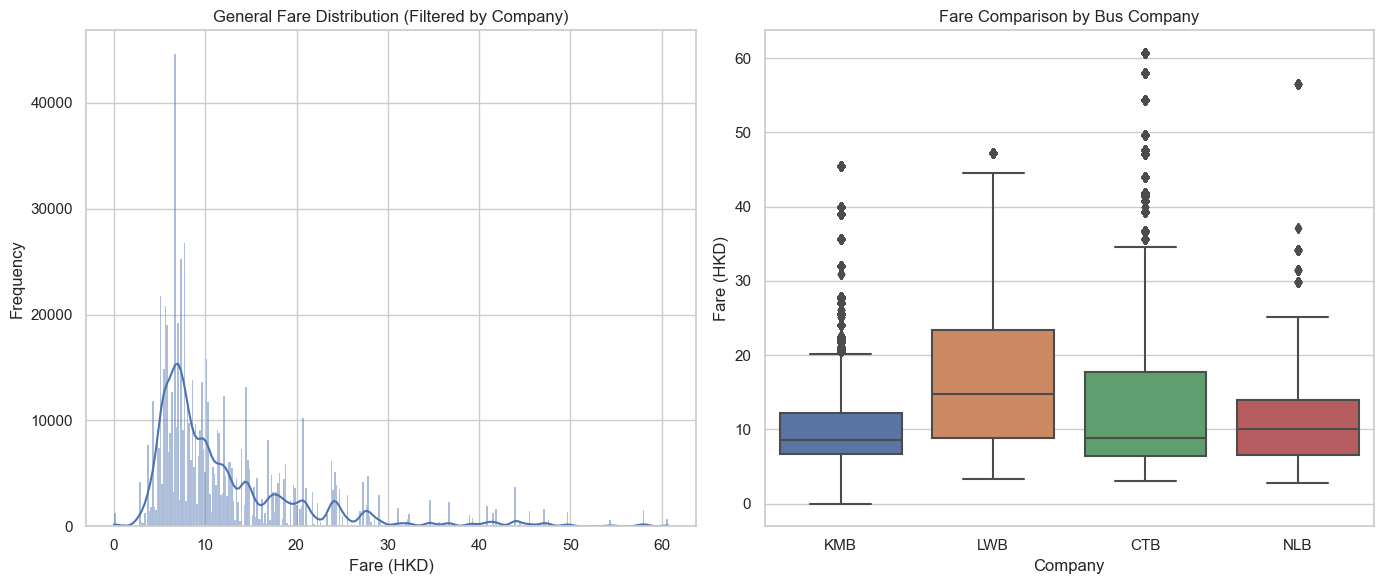

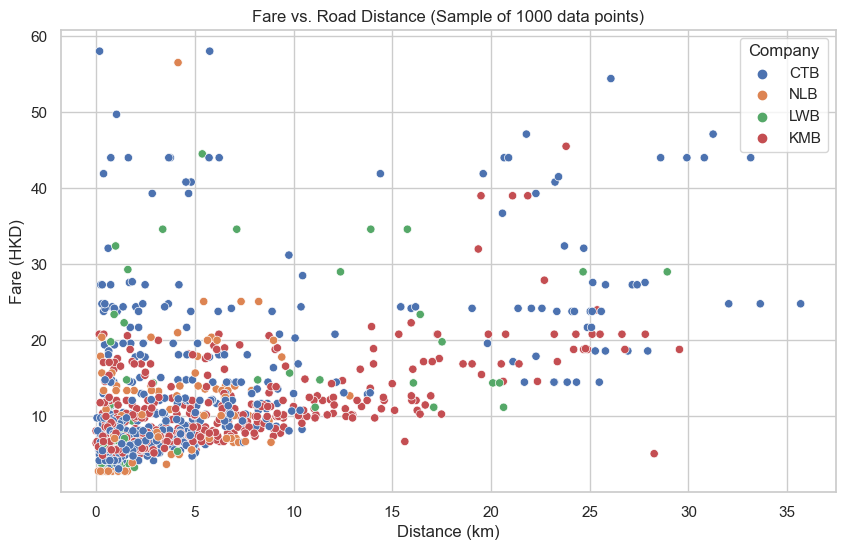

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r"C:\Users\jonch\COMP3522\submission\EDA_Dependencies\Model_data_new.csv"  
data = pd.read_csv(file_path)

# Checking for any missing values in the relevant columns
data = data.dropna(subset=['PRICE', 'COMPANY_CODE_CTB', 'COMPANY_CODE_KMB', 'COMPANY_CODE_LWB', 'COMPANY_CODE_NLB'])

data['Company'] = 'Others'  
data.loc[data['COMPANY_CODE_CTB'] == 1, 'Company'] = 'CTB'
data.loc[data['COMPANY_CODE_KMB'] == 1, 'Company'] = 'KMB'
data.loc[data['COMPANY_CODE_LWB'] == 1, 'Company'] = 'LWB'
data.loc[data['COMPANY_CODE_NLB'] == 1, 'Company'] = 'NLB'

filtered_data = data[data['Company'] != 'Others']

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: General Distribution of Fare 
sns.histplot(data=filtered_data, x="PRICE", kde=True, multiple="stack", ax=axes[0])
axes[0].set_title('General Fare Distribution (Filtered by Company)')
axes[0].set_xlabel('Fare (HKD)')
axes[0].set_ylabel('Frequency')

# Plot 2: Boxplot of Fare by Bus Company
sns.boxplot(x="Company", y="PRICE", data=filtered_data, ax=axes[1])
axes[1].set_title('Fare Comparison by Bus Company')
axes[1].set_xlabel('Company')
axes[1].set_ylabel('Fare (HKD)')


# Show the plots
plt.tight_layout()
plt.show()


#Fare vs Road Distance (using a sample of 1000 for better visualization and computing time)

sample_data = filtered_data.sample(n=1000, random_state=42)

#Plot 3 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DISTANCE_KM', y='PRICE', hue='Company', data=sample_data)
plt.title('Fare vs. Road Distance (Sample of 1000 data points)')
plt.xlabel('Distance (km)')
plt.ylabel('Fare (HKD)')
plt.legend(title='Company')
plt.show()


### Build the OD Matrix ###

##### Version 1 - Macro level transportation #####

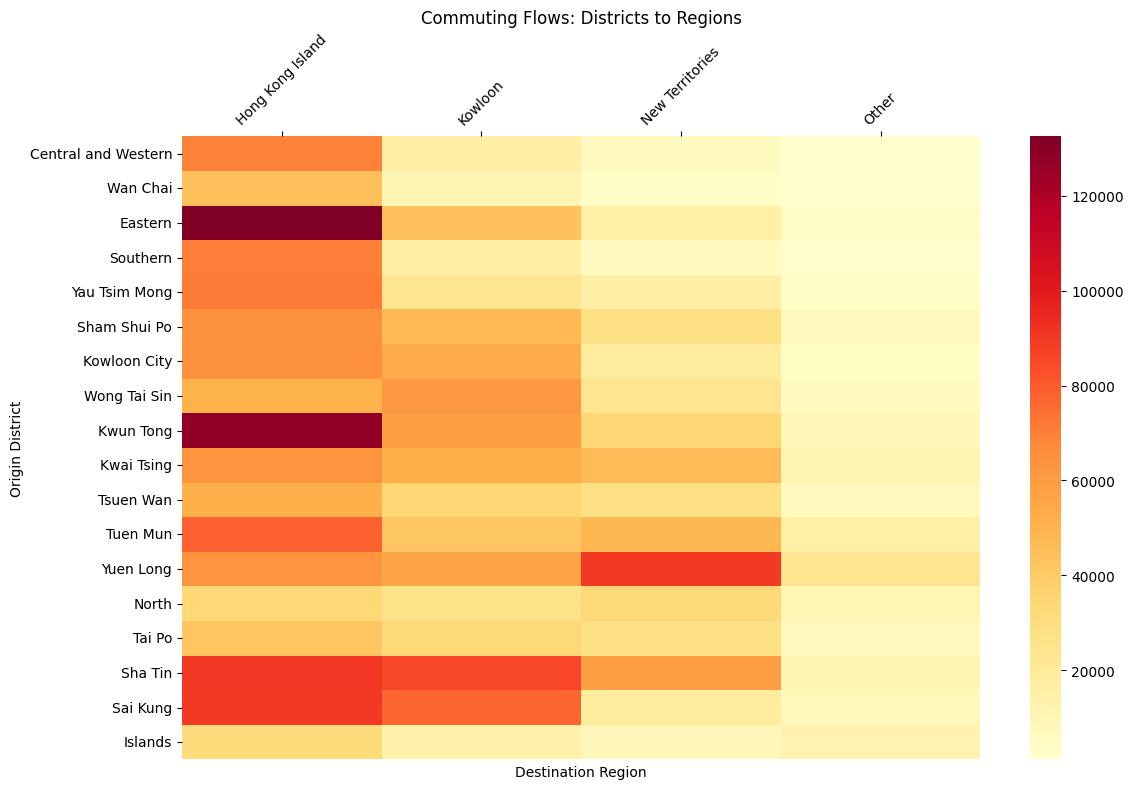

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = r"C:\Users\jonch\COMP3522\submission\EDA_Dependencies\od_matrix_regions.csv"
od_matrix = pd.read_csv(file_path)

#use the origin districts as the index
od_matrix.set_index('District', inplace=True)

plt.figure(figsize=(12, 8))

ax = sns.heatmap(od_matrix, annot=False, cmap="YlOrRd", cbar=True)

plt.title('Commuting Flows: Districts to Regions')
plt.xlabel('Destination Region')
plt.ylabel('Origin District')

ax.xaxis.set_ticks_position('top')

# centered the x lables
ax.set_xticks([i + 0.5 for i in range(len(od_matrix.columns))])
ax.set_xticklabels(od_matrix.columns)

plt.xticks(rotation=45, ha='center')

plt.subplots_adjust(top=0.85)

plt.tight_layout()

plt.show()

##### Version 2 #####

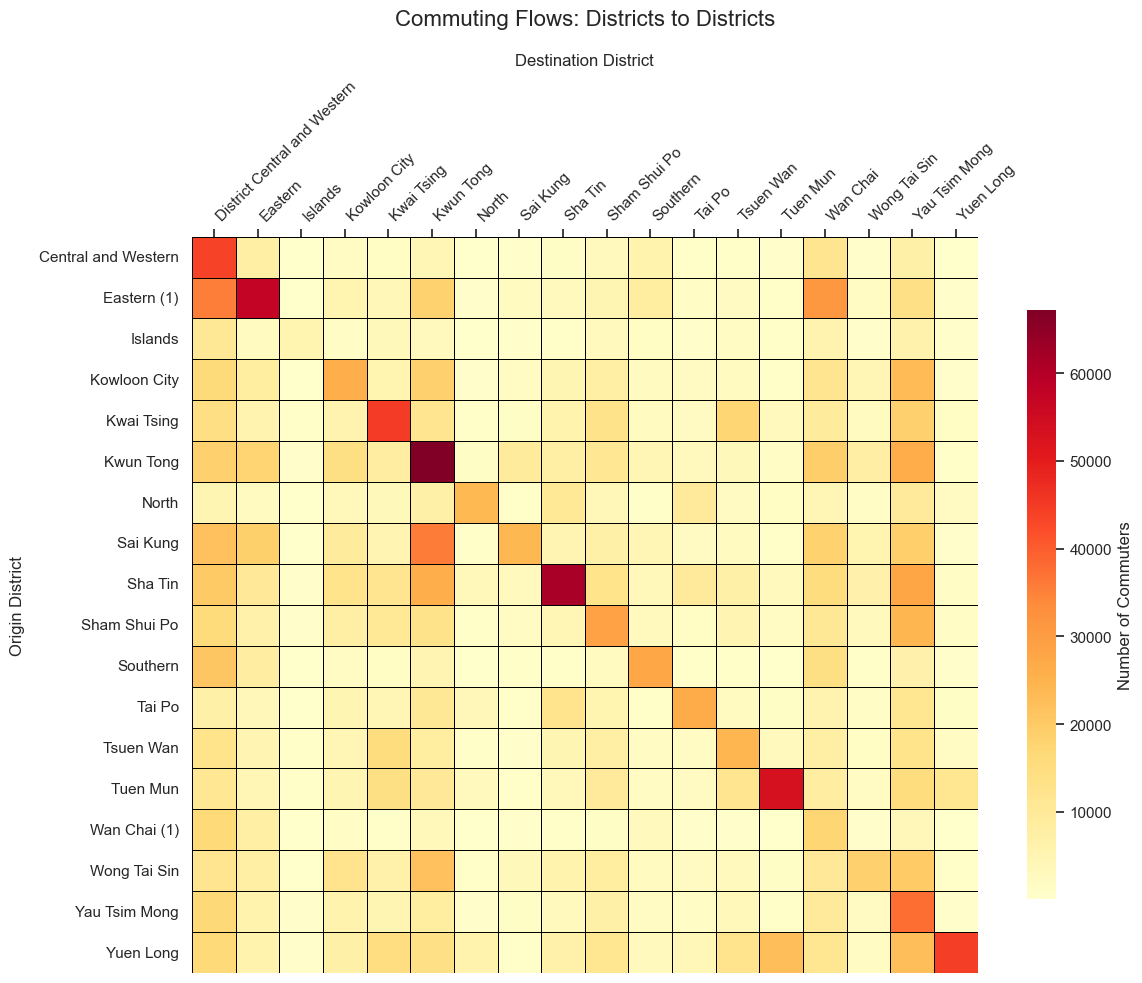

In [ ]:
### Make the plot 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

od_matrix = pd.read_csv(r"C:\Users\jonch\COMP3522\submission\EDA_Dependencies\OD_Matrix_New.csv", index_col = 0)


sns.set_theme(style="whitegrid")  
plt.figure(figsize=(12, 10))      

heatmap = sns.heatmap(
    od_matrix,               
    #annot=True,              
    fmt="d",                 
    cmap="YlOrRd",            
    linewidths=0.5,          
    linecolor="black",        
    cbar_kws={"shrink": 0.8, "label": "Number of Commuters"} 
)

# Add title and labels
plt.title("Commuting Flows: Districts to Districts", fontsize=16, pad=20)
plt.xlabel("Destination District", fontsize=12, labelpad=10)
plt.ylabel("Origin District", fontsize=12, labelpad=10)

heatmap.xaxis.tick_top()  
heatmap.xaxis.set_label_position('top') 

plt.xticks(rotation=45, ha="left")

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()